In [24]:
# -----------------------------
# Day 5 — Random Forest + SMOTE
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

In [7]:
# 1️⃣ Load dataset
df = pd.read_csv("/Users/waheedkehinde/Desktop/fraud-detection-app/data/raw/creditcard.csv")
X = df.drop("Class", axis=1)
y = df["Class"]


In [8]:
# 2️⃣ Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
# 3️⃣ Apply SMOTE on training set
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_sm.value_counts())

/Users/waheedkehinde/Desktop/fraud-detection-app/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Before SMOTE:
 Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE:
 Class
0    227451
1    227451
Name: count, dtype: int64


In [12]:
# 4️⃣ Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # helps with imbalance
)
rf.fit(X_train_sm, y_train_sm)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [13]:
# 5️⃣ Predictions & probabilities
y_probs = rf.predict_proba(X_test)[:, 1]


In [14]:
# 6️⃣ Evaluate at default threshold 0.5
y_pred = (y_probs >= 0.5).astype(int)

print("Classification Report (threshold=0.5):\n")
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report (threshold=0.5):

              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8283    0.8367    0.8325        98

    accuracy                         0.9994     56962
   macro avg     0.9140    0.9182    0.9161     56962
weighted avg     0.9994    0.9994    0.9994     56962

ROC-AUC: 0.9685
Confusion Matrix:
 [[56847    17]
 [   16    82]]


In [19]:
# 1️⃣ Define thresholds
thresholds = np.arange(0.01, 1.0, 0.05)

In [21]:

# 2️⃣ Store metrics
results = []

for threshold in thresholds:
    y_pred_thresh = (y_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, pos_label=1, average='binary')
    
    results.append({
        "threshold": threshold,
        "precision_fraud": precision,
        "recall_fraud": recall,
        "f1_fraud": f1
    })

results_df = pd.DataFrame(results)

In [22]:
# 3️⃣ Find optimal threshold (max F1 for fraud)
optimal_idx = results_df['f1_fraud'].idxmax()
optimal_threshold = results_df.loc[optimal_idx, 'threshold']

print("Optimal threshold based on max F1 for fraud:", optimal_threshold)


Optimal threshold based on max F1 for fraud: 0.66


In [23]:
# 4️⃣ Evaluate at optimal threshold
y_pred_opt = (y_probs >= optimal_threshold).astype(int)
print("\nClassification Report at Optimal Threshold:\n")
print(classification_report(y_test, y_pred_opt, digits=4))

roc_auc_opt = roc_auc_score(y_test, y_probs)
print("ROC-AUC (unchanged):", roc_auc_opt)

print("Confusion Matrix at Optimal Threshold:\n", confusion_matrix(y_test, y_pred_opt))



Classification Report at Optimal Threshold:

              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9186    0.8061    0.8587        98

    accuracy                         0.9995     56962
   macro avg     0.9591    0.9030    0.9292     56962
weighted avg     0.9995    0.9995    0.9995     56962

ROC-AUC (unchanged): 0.9685208460142639
Confusion Matrix at Optimal Threshold:
 [[56857     7]
 [   19    79]]


# -----------------------------
# Random Forest Feature Importance
# -----------------------------

In [25]:
# Extract feature importances from the trained Random Forest
importances = rf.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

In [26]:

# Display top 10 features
print(feat_imp_df.head(10))

   feature  importance
14     V14    0.204506
4       V4    0.132204
10     V10    0.124583
12     V12    0.100190
17     V17    0.092644
3       V3    0.067372
16     V16    0.049786
11     V11    0.048795
2       V2    0.031428
9       V9    0.021057


/var/folders/dm/rj39z9g931b_3l4knh85ncbc0000gn/T/ipykernel_14284/2206231329.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_imp_df.head(10), palette="viridis")


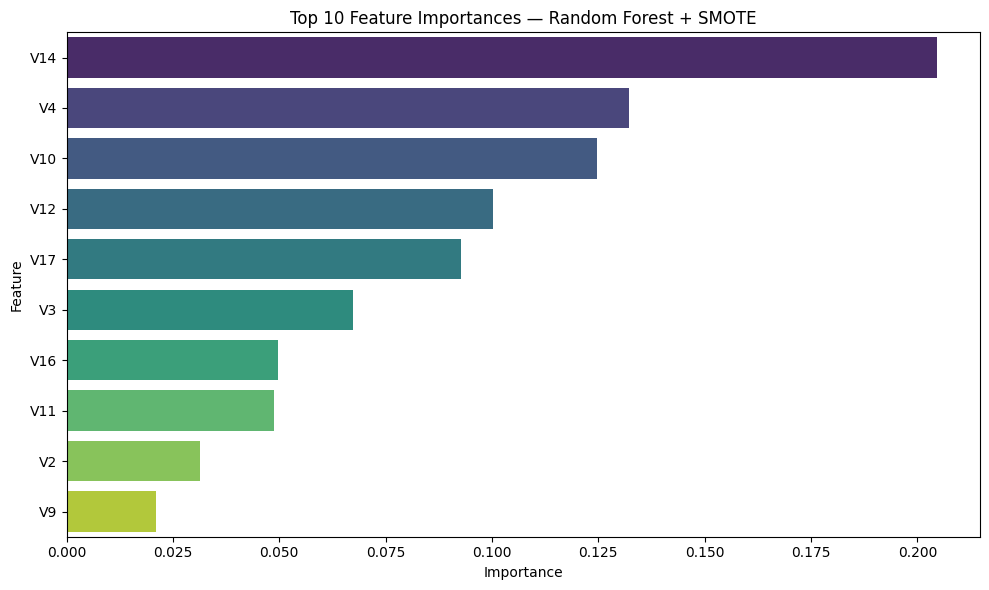

In [27]:
# Plot top 10 feature importances
plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp_df.head(10), palette="viridis")
plt.title("Top 10 Feature Importances — Random Forest + SMOTE")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Random Forest + SMOTE
Objective

To understand which features contribute most to fraud detection in the Random Forest model trained on SMOTE-balanced data. Feature importance helps with:

Model interpretability

Trust and explainability

Guiding future feature engineering

Top 10 Most Important Features
Rank	Feature	Importance
1	V14	0.2045
2	V4	0.1322
3	V10	0.1246
4	V12	0.1002
5	V17	0.0926
6	V3	0.0674
7	V16	0.0498
8	V11	0.0488
9	V2	0.0314
10	V9	0.0211

Key Observations

V14 is by far the most influential feature, contributing over 20% of the model’s decision power.

Features such as V4, V10, V12, and V17 also play a significant role in distinguishing fraudulent transactions.

Most high-impact features are PCA-transformed variables, indicating that fraud patterns are captured in complex, non-obvious combinations of original attributes.

Traditional features like Amount and Time (if included) are less dominant compared to PCA components.

Interpretation

The Random Forest model relies heavily on a small subset of features, which suggests:

Strong underlying fraud signals

Potential for dimensionality reduction or model simplification

These findings are consistent with prior research on the Kaggle credit card fraud dataset, where V14, V10, and V12 frequently emerge as top predictors.

Takeaway

Feature importance analysis confirms that the model is learning meaningful and realistic fraud patterns, strengthening confidence in both performance and interpretability.

This step also prepares the project for:

Model explainability discussions

Stakeholder communication

Future deployment considerations